<img src="images/strathclyde_banner.png" width="50%" align="left" style="left">

# OFDM Transceiver

Following on from OFDM Fundamentals, this notebook introduces the major components of an OFDM transceiver. This includes a demonstration of multipath channel estimation and the one-tap or Zero Forcing (ZF) equaliser. 

## Aims 

* Review major steps in OFDM transmitter 
* Pass signal through multipath channel and add AWGN noise 
* Review major steps in OFDM receiver 
* Demonstrate channel estimation and the one-tap equaliser

##  Table of Contents 

* [1. Introduction](#introduction)
* [2. OFDM Transmitter](#ofdmtx)
   * [2.1 Training Symbol Generation](#training)
   * [2.2 OFDM Symbol Generation](#data)
* [3. Wireless Channel](#channel)
* [4. OFDM Receiver](#ofdmrx)
   * [4.1 Channel Estimation](#chanest)
   * [4.2 Channel Equalisation](#chaneq)
* [5. Conclusion](#conclusion)

## 1. Introduction <a class="anchor" id="introduction"></a>

In this notebook, an overview of the main steps in an OFDM transceiver are provided. On the transmit side, this includes symbol generation, IFFT modulation and Cyclic Prefix (CP) addition. The OFDM signal is then passed through a baseband channel model, including multipath channel filter and Additive White Gaussian Noise (AWGN). The receiver stages include CP removal, FFT demodulation, channel estimation and one-tap equalisation. In order to assess the quality of the received signal, we inspect the received constellations before and after equalisation. 

We will also mention some important aspects of the OFDM transceiver which are not explicitly covered in this notebook, such as timing and frequency synchronisation.    

## 2. OFDM Transmitter <a class="anchor" id="ofdmtx"></a>

In this section, we will demonstrate some of the main steps in an OFDM transmitter. Firstly, let's import the necessary libraries and helper functions:

In [85]:
# Import necessary libraries 
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy import signal

# Import helper function
from pystrath_dsp.helper_functions import symbol_gen, psd, \
frequency_plot, scatterplot, calculate_evm, awgn

[Figure 2.1](#fig-2.1) shows the stages of the OFDM transmitter that will be demonstrated in this notebook:

<a class="anchor" id="fig-2.1"></a>
<figure>
<img src="images/ofdm_tx_3 copy.svg" style="width: 1000px;"/> 
    <figcaption><b>Figure 2.1: OFDM Transmitter</b></figcaption>
</figure>    

This is very similar to the final OFDM transmitter diagram shown in [OFDM Fundamentals](01_ofdm_fundamentals.ipynb). However, we have now addded a sub-carrier mapping stage after symbol generation. This is necessary because in real OFDM systems, only particular sub-carriers are used to carry data. The remaining sub-carriers are used to carry pilots for phase tracking and channel estimation in the receiver and null sub-carriers to relax the requirements for anti-imaging and anti-aliasing filters in the transmitter and receiver respectively.  

In this notebook, we will use the OFDM symbol structure and sub-carrier mapping scheme employed in the IEEE 802.11a/g (Wi-Fi) standard. However, we will restrict ourselves to the addition of null sub-carriers, since we will not demonstrate phase tracking and will training symbols for channel estimation. The implementation of phase tracking can be seen in the RFSoC demonstration notebook.   

Let's set some important OFDM parameters: 

In [86]:
fs = 20e6 # Sampling rate 
N = 64 # No. of sub-carriers 

### 2.1 Training Symbol Generation <a class="anchor" id="training"></a>

As mentioned previously, channel estimation will be performed using training symbols, known to both transmitter and receiver. This will be based on the Legacy Long Training Field (L-LTF), used in the IEEE 802.11a/g standard. The L-LTF consists of two training OFDM symbols (each with length $N$ = 64) preceded by a 32 sample CP. As a result, it is 160 samples long.  

The generation of the L-LTF is based on the following sequence:

In [87]:
#L-LTF sequence
LTFseq = np.array([0,0,0,0,0,0,1,1,-1,\
                  -1,1,1,-1,1,-1,1,1,1,\
                  1,1,1,-1,-1,1,1,-1,1,\
                  -1,1,1,1,1,0,1,-1,-1,\
                  1,1,-1,1,-1,1,-1,-1,\
                  -1,-1,-1,1,1,-1,-1,1,\
                  -1,1,-1,1,1,1,1,0,0,0,\
                  0,0])

In reference to [Figure 2.1](#fig-2.1), we have already completed the symbol generation and sub-carrier mapping stages. A total of 52 Binary Phase Shift Keying (BPSK) symbols have been generated (1,-1) and have been mapped to 52 OFDM sub-carriers. The remaining 12 sub-carriers are set to zero and these are the null sub-carriers. This includes the DC sub-carrier at the centre of the spectrum, 6 on the left edge of the frequency band and 5 on the right edge.   

We can now perform the IFFT to generate the training symbol:

In [88]:
LTFsymb = np.fft.ifft(np.fft.fftshift(LTFseq),N)

An FFT shift is performed to map the symbols to the correct IFFT bins. This is because the IFFT operates from $[0, f_{s})$, whereas the sub-carriers are mapped assuming a frequency range $[-f_{s}/2, f_{s}/2)$.  

Finally, to generate the L-LTF, we repeat the symbol twice and add a 32 sample CP. 

In [89]:
# Extract 32 sample CP 
LTFcp = LTFsymb[32:64]

# Concatenate to form L-LTF
LLTF = np.concatenate((LTFcp, LTFsymb, LTFsymb))

The L-LTF is used for channel estimation in this notebook. However, it can also be used for fine timing synchronisation, fine frequency synchronisation and integer frequency offset estimation in the receiver. In the IEEE 802.11a/g standard, another training symbol called the Legacy Short Training Field (L-STF) is also used. This will not be covered here. However, it can be used for Automatic Gain Control (AGC) convergence, timing synchronisation and frequency offset estimation.   

### 2.2 OFDM Symbol Generation <a class="anchor" id="data"></a>

Having created the L-LTF, we will now go on to generate our data payload. This consists of a variable number of OFDM symbols carrying randomly generated (BPSK,QPSK,16-QAM) data symbols. We will add a CP of length $N/4 = 16$ samples to each OFDM symbol.
Let's generate a block of $N_{ofdm}N_{data}$ data symbols, where $N_{ofdm}$ is the number of OFDM symbols in the payload and $N_{data}$ is the number of data carrying sub-carriers:  

In [90]:
n_ofdm = 1000 # No. of OFDM symbols
n_data = 52 # No. of data sub-carriers
nsym = n_ofdm * n_data # No. of data symbols
mod_scheme = 'QPSK' # Modulation scheme

# Generate data symbols
data = symbol_gen(nsym,mod_scheme)

We will now perform sub-carrier mapping and IFFT modulation to obtain the OFDM symbols. The data symbols will be mapped in the same manner as the L-LTF sequence and there will be null sub-carriers at DC and on the band edges.

In [91]:
# Indices for data sub-carriers 
ind_1 = np.arange(start=6, stop=32)
ind_2 = np.arange(start=33, stop=59)
index = np.concatenate((ind_1, ind_2), axis=0)

# Initialisation of array to hold OFDM symbols 
ofdm_data = np.zeros(n_ofdm*N,np.complex64)
j = 0 
k = 0 

for i in range(n_ofdm):
    
    # Initialise array to hold data and null sub-carriers
    # (all null to begin with)
    sc_array = np.zeros(N,np.complex64)
    
    # Map data symbols to correct sub-carrier positions
    sc_array[index] = data[j:j+n_data] 
    
    # Perform IFFT modulation
    ofdm_data[k:k+N] = np.fft.ifft(np.fft.fftshift(sc_array),N) 
    
    # Increment
    j = j + n_data
    k = k + N

We will now add the 16 sample CP to the beginning of each OFDM symbol:

In [92]:
# Define function to add CP 
def add_cp(ofdm_symb,N,cp_len):
    
    #Extract CP
    cp = ofdm_symb[N-cp_len:N:1]
    
    # Concatenate CP and symbol 
    ofdm_symb_cp = np.concatenate((cp,ofdm_symb))
    
    return ofdm_symb_cp

cp_len = N // 4 # CP length is 1/4 of symbol period

# Add CP to each of the ofdm symbols 
ofdm_data_cp = np.zeros(n_ofdm*(N+cp_len),np.complex64)
j = 0
k = 0 

for i in range(n_ofdm):    
    ofdm_data_cp[k:(k+N+cp_len)] = add_cp(ofdm_data[j:j+N],N,cp_len)
    j = j + N  
    k = k + N + cp_len 

In order to create the final transmit signal, we attach the L-LTF at the beginning of the data payload. As such, the L-LTF is transmitted first:

In [93]:
# Concatenate L-LTF and data payload to form final transmit signal 
txSig = np.concatenate((LLTF,ofdm_data_cp))

## 3. Wireless Channel <a class="anchor" id="channel"></a>

At this stage, we will pass the OFDM signal through a baseband model of the wireless channel. The channel is comprised of a multipath filter and AWGN as illustrated below:  

<a class="anchor" id="fig-3.1"></a>
<figure>
<img src="images/channel copy.svg" style="width: 700px;"/> 
    <figcaption><b>Figure 3.1: Baseband Channel Model </b></figcaption>
</figure>

For the multipath channel filter, we will employ a standard 4-tap FIR filter with complex weights drawn from a zero mean normal distribution. This is similar to the procedure used to simulate a Rayleigh Fading channel. With a 4 tap FIR, $d_{s}$ is equal to 3 sampling periods, meaning that the CP of length 16 is more than sufficient.

In [94]:
# Filter coefficients
ntap = 4
h = np.random.randn(ntap) + np.random.randn(ntap)*1j

# Appy channel filter 
txSig_filt = np.convolve(txSig, h)

The AWGN is added with a power that is calculated based on a desired SNR: 

In [95]:
SNR = 30 # Desired SNR (dB) 
rxSig = awgn(txSig_filt,SNR)

## 4. OFDM Receiver <a class="anchor" id="ofdmrx"></a>

An illustration of the OFDM receiver steps is shown below: 


<a class="anchor" id="fig-4.1"></a>
<figure>
<img src="images/ofdm_rx copy.svg" style="width: 1000px;"/> 
    <figcaption><b>Figure 4.1: OFDM Receiver</b></figcaption>
</figure>

We will start by extracting the L-LTF symbols and demodulating them using the FFT. These will be used for channel estimation purposes. In this example, we know the exact timing of the beginning of each symbol. However, in practice, this is unknown and an appropriate timing synchronisation algorithm must be used to acquire symbol timing. Also, due to oscillator offsets between transmitter and receiver and Doppler effects, a frequency synchronisation stage must be performed prior to the FFT in order to minimise the potential for Inter Carrier Interference (ICI).  

The beginning of the first L-LTF OFDM symbol is sample 33 i.e. immediately after the 32 sample CP: 

In [96]:
# Extract received L-LTF OFDM symbols 
rx_LLTF_symb_1 = rxSig[32:96]
rx_LLTF_symb_2 = rxSig[96:160]

Let's now take the FFT of each of them to recover the transmitted sequences: 

In [97]:
LLTF_symb_demod_1 = np.fft.fftshift(np.fft.fft(rx_LLTF_symb_1,N))
LLTF_symb_demod_2 = np.fft.fftshift(np.fft.fft(rx_LLTF_symb_2,N))

Ok, we'll leave these for now and return to them when we do channel estimation. Now let's extract the data payload OFDM symbols and perform FFTs to recover the underlying data symbols. The CP is removed because it does not contain any information.

In [98]:
# Function to demodulate OFDM 
def ofdm_demod(ofdm_rx,N,cp_len):
    
    # Remove CP 
    ofdm_u = ofdm_rx[cp_len:(N+cp_len)]
    
    # Perform FFT 
    data = np.fft.fftshift(np.fft.fft(ofdm_u,N))
    
    return data

# Array to hold recovered  data symbols  
data_rx = np.zeros(n_ofdm*n_data,np.complex64)
j = 0
k = 0 

# Extract data payload (after end of L-LTF)
L = len(rxSig)
rxPayload = rxSig[160:L:1]

# Demodulate OFDM symbols in payload 
for i in range(n_ofdm):
    
    # Demodulate OFDM symbols 
    rx_demod = ofdm_demod(rxPayload[k:(k+N+cp_len)],N,cp_len)
    
    # Extract data symbols 
    data_rx[j:j+n_data] = rx_demod[index] 
    
    j = j + n_data
    k = k + N + cp_len 

### 4.1 Channel Estimation <a class="anchor" id="chanest"></a>

At this stage, we will perform channel estimation. Recall that the channel effect is reduced to a single complex multiplication per sub-carrier. The received symbol on sub-carrier $k$, $Y[k]$, in any given OFDM symbol is given by:    

$$ Y[k] = H[k]X[k] + W[k],$$

where $Y[k]$ is the $k^{th}$ received data symbol, $X[k]$ is the $k^{th}$ transmitted data symbol, $H[k]$ is the frequency response at sub-carrier $k$ and $W[k]$ is the noise at sub-carrier $k$.  

The data symbols transmitted in the L-LTF symbols are known to the receiver. Therefore, we can estimate the channel by dividing through by $X[k]$, leading to:

$$ \hat{H}[k] = \frac{Y[k]}{X[k]} = H[k] + \frac{W[k]}{X[k]} = H[k] + \alpha_{k}, $$

where $\hat{H}[k]$ is the $k^{th}$ channel estimate. The quantity $W[k]/X[k]$ is an unwanted noise term which we denote as $\alpha_{k}$. Since we have two OFDM symbols in the L-LTF, we can generate two channel estimates. Let's extract the symbols on the data sub-carriers, since the null sub-carriers don't carry any information:

In [99]:
# Extract data sub-carriers
LLTF_data_1 = LLTF_symb_demod_1[index]
LLTF_data_2 = LLTF_symb_demod_2[index] 

In [100]:
# Get channel estimates 
h_1 = LLTF_data_1 / LTFseq[index]
h_2 = LLTF_data_2 / LTFseq[index]

Since the channel effect is not changing over time, we can average $h_{1}$ and $h_{2}$ to produce a final channel estimate:

In [101]:
# Average h_1 and h_2 to get final estimate 
h_final = (h_1 + h_2) / 2

Taking an average of the two estimates reduces the effects of noise. As alluded to previously, using the L-LTF for channel estimation assumes that the channel response does not change between the start of the L-LTF and the end of the data payload. This is a reasonable assumption for typical Wi-Fi deployments.  

Let's now compare the estimated magnitude and phase responses of the channel at the data sub-carriers, with the actual magnitude and phase responses of the channel at these positions:

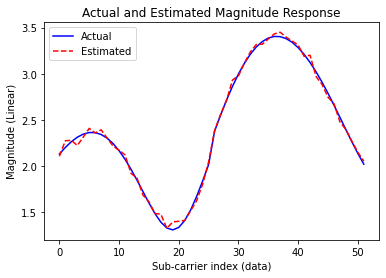

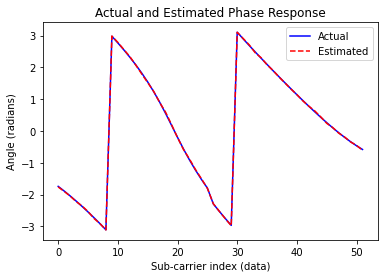

In [102]:
# Calculate magnitude and phase response of channel 
chan = np.fft.fftshift(np.fft.fft(h,N))
chan_data = chan[index]

# Plot actual and estimated magnitude response
plt.plot(abs(chan_data),'b')
plt.plot(abs(h_final),'--r')
plt.title('Actual and Estimated Magnitude Response')
plt.xlabel('Sub-carrier index (data)')
plt.ylabel('Magnitude (Linear)')
plt.legend(('Actual','Estimated'))

plt.figure(2)

# Plot actual and estimated phase response
plt.plot(np.angle(chan_data),'b')
plt.plot(np.angle(h_final),'--r')
plt.title('Actual and Estimated Phase Response')
plt.xlabel('Sub-carrier index (data)')
plt.ylabel('Angle (radians)')
plt.legend(('Actual','Estimated'))

The sub-carrier index has been changed to 0 to 51, since there are a total of 52 data sub-carriers. As you decrease the SNR, you'll notice that the difference between the actual and estimated frequency responses increases. This is because when the noise power increases, $\alpha_{k}$ also increases. As shown above, the contribution of $\alpha_{k}$ can be reduced by averaging the channel estimates for the $k^{th}$ sub-carrier over time. The number of available channel estimates to be averaged depends on how regularly the channel is estimated and the length of time over which the channel repsonse remains constant.     

### 4.2 Channel Equalisation <a class="anchor" id="chaneq"></a>

In OFDM, there are two common equalisation methods; the one-tap or Zero Forcing (ZF) equaliser and the Minimum Mean Square Error (MMSE) equaliser. At this stage, we will restrict our discussion to the ZF equaliser. The MMSE will be introduced in a further iteration of the notebook.   

The one-tap or ZF equaliser is the most computationally efficient equalisation method. It is given by: 

$$ \hat{X}[k] = \frac{Y[k]}{\hat{H}[k]}. $$

Before expanding the above equation, let's assume that sufficient time averaging of channel estimates has been performed such that $\alpha_{k} = 0$. This will simplify the expanded expression. Therefore, we arrive at:

$$ \hat{X}[k] = \frac{Y[k]}{\hat{H}[k]} = \frac{X[k]H[k] + W[k]}{H[k]} = X[k] + \frac{W[k]}{H[k]}.$$

Inspecting the above, we see that the equalised symbol includes an error term, $W[k]/H[k]$. This error term has a detrimental effect on the performance of the ZF equaliser because when $|H[k]|$ is close to zero, i.e. when the channel is in a deep fade, the $W[k]$ or noise term is amplified. Moreover, as the noise power increases, the amplification has a more severe effect. These issues lead to an SNR degradation after the ZF equaliser.

Based on the procedure for complex division, the ZF equaliser can be re-written as:

$$ \hat{X}[k] = Y[k]\frac{\hat{H}^{*}[k]}{|\hat{H}[k]|^{2}}, $$

where * denotes complex conjugation. The term $\frac{\hat{H}^{*}[k]}{|\hat{H}[k]|^{2}}$ is referred to as the ZF equaliser gain. 

Let's now inspect the received constellation before applying the ZF equaliser.  

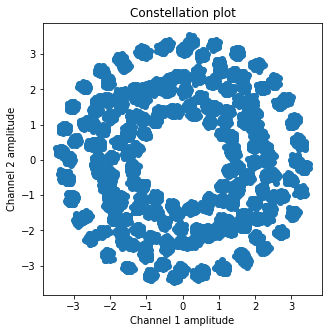

In [103]:
# Plot constellation 
scatterplot(data_rx.real,data_rx.imag,ax=None)

It is clear that the received constellations are heavily distorted. Without equalisation, this would lead to a large number of symbol and bit errors. In the next cell, we will equalise the data symbols using the channel estimate from the previous section:

In [104]:
# Equalise data symbols 
data_eq_zf = np.zeros(n_ofdm*n_data,np.complex64)
j = 0

for i in range (n_ofdm):
    
    data_eq_zf[j:j+n_data] = data_rx[j:j+n_data] * (np.conj(h_final)/abs(h_final)**2)
    
    j = j + n_data

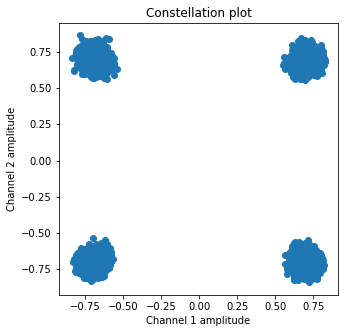

In [105]:
# Plot constellation 
scatterplot(data_eq_zf.real,data_eq_zf.imag,ax=None)

Try running the notebook several times and look at the received constellation after ZF equalisation. You will notice that even for high SNRs, the constellation can still be very distorted. This becomes especially evident when employing 16-QAM. This is due to the noise amplification that occurs when the  channel experiences deep fades. Have a look at the channel magnitude response to confirm the presence (or not!) of a deep fade. Note, in practice, the use of Forward Error Correction (FEC) in OFDM systems can help to improve the error rate performance in channels with deep fades. It is also possible to reduce the modulation order on sub-carriers affected by a deep fade to improve robustness, if there is a mechanism in place to feedback the Channel State Information (CSI) to the transmitter. 

The noise amplification issue associated with the ZF equaliser can be reduced by employing an MMSE equaliser, albeit with an increase in computational complexity.         

## 5. Conclusion <a class="anchor" id="conclusion"></a>

In this notebook, we have demonstrated the major steps in an OFDM transceiver chain. This includes symbol generation, IFFT modulation and CP addition on the transmit side and CP removal, FFT demodulation, channel estimation and one-tap equalisation on 
the receive side. The equalised constellations were plotted as a qualitative measure of received signal quality.  